### Import the necessary libraries

In [2]:
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras import layers, models
import requests

### Loading the data

In [3]:
# load the data
df = pd.read_pickle('data/words_df.pkl.gz')

In [4]:
df.head()

,WordID,GrayLevel,BoundingBox,GrammaticalTag,Transcription,ImageData
0,a01-000u-03-00,156,"(430, 1290, 177, 59)",NPTS,M Ps,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
1,a01-000u-03-01,156,"(705, 1296, 431, 54)",NR,tomorrow,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
2,a01-000u-03-02,156,"(1154, 1346, 9, 10)",.,.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
3,a01-000u-03-03,156,"(1269, 1292, 320, 68)",NPT,Mr.,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."
4,a01-000u-03-04,156,"(1570, 1297, 252, 56)",NP,Michael,"[[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0..."


In [5]:
print(df.shape)

(18863, 6)


### Splitting train, validation, and test data

In [6]:
count=0
c2=0
for i, img in enumerate(df['ImageData']):
    try:
        if img.shape == (32, 128, 1):  # Replace with your expected dimensions
            count+=1
    except AttributeError:
        print(f"{df['WordID'][i]} will be deleted")
        df.drop([i], inplace=True)
        c2+=1
print(count)
print(c2)

18863
0


2 images data weren't loaded into the dataframe. Delete those rows.

In [7]:
print(len(df['Transcription'].unique()))

4582


In [8]:
# calculate the longest word
max_len = 0
for word in df['Transcription']:
    if len(word) > max_len:
        max_len = len(word)
print(max_len)

18


In [9]:
# Split data into training and validation sets
X = np.stack(df['ImageData'].values)  # Convert the list of images to a numpy array
y = df['Transcription'].values

In [10]:
# print the top 40 value counts of the array y
print(pd.Series(y).value_counts()[:10])

,      1194
.       890
the     840
"       538
of      451
to      396
and     365
a       314
in      285
'       253
Name: count, dtype: int64


In [11]:
def encode_to_labels(y):
    # create a list of the chartcaters vocabulary ordered alphabetically
    vocabulary = sorted(set(''.join(y)))

    # create a dictionary mapping each character to the vocabulary list index. do not use 0.
    char_to_num = {char:idx+1 for idx, char in enumerate(vocabulary)}

    # transform y values to numerical using the char_to_num dictionary, using 0 for padding. the length of each word is the maximum length of the words in the dataset
    y_encoded = []
    for word in y:
        word_encoded = [char_to_num[char] for char in word]
        y_encoded.append(word_encoded)

    # pad the encoded values (fill with 0s to the right)
    y_encoded = tf.keras.preprocessing.sequence.pad_sequences(y_encoded, padding='post')

    return y_encoded

y = encode_to_labels(y)

In [12]:
print(X.shape)
print(y.shape)

(18863, 32, 128, 1)
(18863, 18)


In [13]:
TRAIN_SPLIT = 0.8
VAL_SPLIT = 0.1
TEST_SPLIT = 0.1

# split the data into training, validation and test sets
X_train = X[:int(X.shape[0]*TRAIN_SPLIT)]
y_train = y[:int(y.shape[0]*TRAIN_SPLIT)]

X_val = X[int(X.shape[0]*TRAIN_SPLIT):int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]
y_val = y[int(y.shape[0]*TRAIN_SPLIT):int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT))]

X_test = X[int(X.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]
y_test = y[int(y.shape[0]*(TRAIN_SPLIT+VAL_SPLIT)):]

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(15090, 32, 128, 1)
(15090, 18)
(1886, 32, 128, 1)
(1886, 18)
(1887, 32, 128, 1)
(1887, 18)


### Neural Networks

#### (Model 1) Starting simple

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_improved_cnn(input_shape, output_length, num_classes):
    model = models.Sequential()

    # First Convolutional Block
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Second Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Third Convolutional Block
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Global Average Pooling replaces Flatten
    model.add(layers.GlobalAveragePooling2D())

    # Dense Layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.3))
    
    # Output layer with 'num_classes' units
    model.add(layers.Dense(num_classes, activation='softmax'))
    
    return model

# Define your parameters
input_shape = X_train.shape[1:]  # Replace with actual shape (32, 128, 1)
output_length = y_train.shape[1]  # Replace with actual length 18
num_classes = 18  # Replace with the actual number of classes

# Create and compile the improved model
model = create_improved_cnn(input_shape, output_length, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# Define a simple CNN model
def create_basic_cnn(input_shape, output_length):
    model = models.Sequential()
    
    # Convolutional layer that extracts features from the input images
    model.add(layers.Conv2D(128, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Additional convolutional layer for more complex features
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Additional convolutional layer for more complex features
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    
    # Flatten the 3D output to 1D
    model.add(layers.Flatten())
    
    # Dense layer for prediction
    model.add(layers.Dense(128, activation='relu'))
    
    # Output layer with 'output_length' units, one for each time step in the output sequence
    model.add(layers.Dense(output_length, activation='softmax'))
    
    return model

# Create the model
input_shape = X_train.shape[1:] # (32, 128, 1)
output_length = y_train.shape[1]  # 18
model = create_basic_cnn(input_shape, output_length)

# Compile the model
adam = Adam(learning_rate=0.001)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 30, 126, 128)      1280      
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 15, 63, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 13, 61, 64)        73792     
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 6, 30, 64)         0         
 ng2D)                                                           
                                                                 
 conv2d_17 (Conv2D)          (None, 4, 28, 64)         36928     
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 2, 14, 64)        

In [29]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))

Epoch 1/10
472/472 [==============================] - 28s 60ms/step - loss: 1075050184704.0000 - accuracy: 0.4510 - val_loss: 4231789281280.0000 - val_accuracy: 0.5037
Epoch 2/10
472/472 [==============================] - 28s 60ms/step - loss: 72107425792000.0000 - accuracy: 0.4517 - val_loss: 113642821386240.0000 - val_accuracy: 0.5037
Epoch 3/10
472/472 [==============================] - 29s 61ms/step - loss: 647180637437952.0000 - accuracy: 0.4517 - val_loss: 690904746688512.0000 - val_accuracy: 0.5037
Epoch 4/10
472/472 [==============================] - 28s 60ms/step - loss: 2728298786324480.0000 - accuracy: 0.4517 - val_loss: 2395175217266688.0000 - val_accuracy: 0.5037
Epoch 5/10
472/472 [==============================] - 28s 60ms/step - loss: 7802723994959872.0000 - accuracy: 0.4517 - val_loss: 6029942957539328.0000 - val_accuracy: 0.5037
Epoch 6/10
472/472 [==============================] - 29s 62ms/step - loss: 17706601825697792.0000 - accuracy: 0.4517 - val_loss: 12420477410

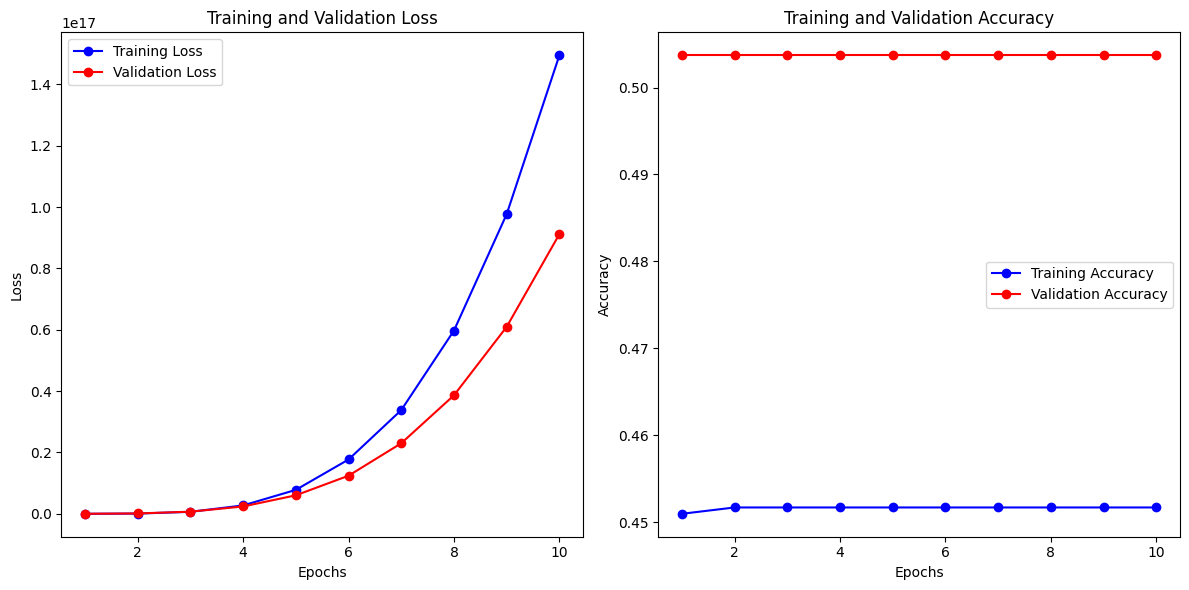

In [30]:
import matplotlib.pyplot as plt

# Assuming you have a history object from the model.fit() method
history_dict = history.history

# Extract the accuracy and loss from the history object
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Determine the number of epochs
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation Loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

59/59 [==============================] - 0s 7ms/step - loss: 6567207932788736.0000 - accuracy: 0.4870
Test Accuracy: 48.70%


In [34]:
# print more metrics about the multi-class classification
from sklearn.metrics import classification_report
y_pred = model.predict(X_test)
y_pred_bool = np.argmax(y_pred, axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred_bool))



59/59 [==============================] - 0s 7ms/step
              precision    recall  f1-score   support

           0       0.49      1.00      0.66       919
           1       0.00      0.00      0.00       331
           2       0.00      0.00      0.00       284
           3       0.00      0.00      0.00       152
           4       0.00      0.00      0.00        85
           5       0.00      0.00      0.00        52
           6       0.00      0.00      0.00        26
           7       0.00      0.00      0.00        23
           8       0.00      0.00      0.00         4
           9       0.00      0.00      0.00         1
          10       0.00      0.00      0.00         5
          11       0.00      0.00      0.00         3
          12       0.00      0.00      0.00         2

    accuracy                           0.49      1887
   macro avg       0.04      0.08      0.05      1887
weighted avg       0.24      0.49      0.32      1887



/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### (Model 2) Adding Embedding layer

In [35]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_model_with_embedding(input_shape, output_length, num_classes):
    # Image model
    image_input = tf.keras.Input(shape=input_shape, name='image_input')
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(image_input)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)

    # Label input for embedding
    label_input = tf.keras.Input(shape=(output_length,), name='label_input')
    label_embedding = layers.Embedding(input_dim=num_classes, output_dim=50)(label_input)
    
    # Combine image features with label embeddings
    combined = layers.concatenate([x, layers.Flatten()(label_embedding)])
    
    # Add a dense layer
    combined = layers.Dense(128, activation='relu')(combined)
    
    # Output layer
    output = layers.Dense(num_classes, activation='softmax')(combined)

    # Create model
    model = models.Model(inputs=[image_input, label_input], outputs=output)

    return model

# Define your parameters
input_shape = (32, 128, 1) 
output_length = 18
num_classes = 18

# Create and compile the model
model = create_model_with_embedding(input_shape, output_length, num_classes)
model.compile(optimizer='adam',
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 image_input (InputLayer)    [(None, 32, 128, 1)]         0         []                            
                                                                                                  
 conv2d_6 (Conv2D)           (None, 32, 128, 32)          320       ['image_input[0][0]']         
                                                                                                  
 max_pooling2d_6 (MaxPoolin  (None, 16, 64, 32)           0         ['conv2d_6[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_7 (Conv2D)           (None, 16, 64, 64)           18496     ['max_pooling2d_6[0][0]'

In [36]:
history = model.fit([X_train, y_train],  # Images and labels as input
                    y_train,  # Labels as targets
                    epochs=10,
                    validation_data=([X_val, y_val], y_val))

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node model_1/embedding_1/embedding_lookup defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3009, in run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3064, in _run_cell

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3269, in run_cell_async

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3448, in run_ast_nodes

  File "/Users/jorgemilhomem/Library/Python/3.11/lib/python/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code

  File "/var/folders/6q/0yfg3pwd67d3xrqsp_16lm680000gn/T/ipykernel_48919/3629021364.py", line 1, in <module>

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 590, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 515, in call

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/opt/homebrew/lib/python3.11/site-packages/keras/src/layers/core/embedding.py", line 272, in call

indices[1,0] = 47 is not in [0, 18)
	 [[{{node model_1/embedding_1/embedding_lookup}}]] [Op:__inference_train_function_221295]

In [ ]:
test_loss, test_acc = model.evaluate([X_test, y_test], y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

59/59 [==============================] - 0s 7ms/step - loss: 36361201717870592.0000 - accuracy: 0.4870
Test Accuracy: 48.70%
